# Synthetic Features and Outliers - Solutions

In [1]:
%%sql --module california_housing
SELECT total_rooms, population, median_house_value FROM $california_housing

In [2]:
import datalab.bigquery as bq
from IPython import display
import math
from matplotlib import cm
from matplotlib import gridspec
import matplotlib.pyplot as plt
import numpy as np
from numpy import linspace
import pandas as pd
import sklearn.metrics as metrics
import tensorflow as tf

tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

california_housing_dataframe = bq.Query(
    california_housing, california_housing=bq.Table('mlcc-playground:california_housing.train')
).to_dataframe()

california_housing_dataframe = california_housing_dataframe.reindex(
    np.random.permutation(california_housing_dataframe.index))
california_housing_dataframe["median_house_value"] /= 1000.0
california_housing_dataframe

,total_rooms,population,median_house_value
8331,1891.0,1047.0,86.1
12542,2990.0,1849.0,216.1
2390,1584.0,1011.0,58.8
12389,2252.0,1370.0,184.8
5146,3127.0,1015.0,78.8
...,...,...,...
4177,2030.0,910.0,343.3
4300,1416.0,779.0,279.8
7728,1651.0,1062.0,215.4
10592,4038.0,2065.0,178.1


In [3]:
def train_model(learning_rate, steps, batch_size, input_feature):
  """Trains a linear regression model of one feature.
  
  Args:
    learning_rate: A `float`, the learning rate.
    steps: A non-zero `int`, the total number of training steps. A training step
      consists of a forward and backward pass using a single batch.
    batch_size: A non-zero `int`, the batch size.
    input_feature: A `string` specifying a column from `california_housing_dataframe`
      to use as input feature.
      
  Returns:
    A Pandas `DataFrame` containing targets and the corresponding predictions done
    after training the model.
  """
  
  periods = 10
  steps_per_period = steps / periods

  my_feature = input_feature
  my_feature_column = california_housing_dataframe[my_feature].astype('float32')
  my_label = "median_house_value"
  targets = california_housing_dataframe[my_label].astype('float32')

  # Create a linear regressor object.
  feature_columns = tf.contrib.learn.infer_real_valued_columns_from_input(
      my_feature_column)
  linear_regressor = tf.contrib.learn.LinearRegressor(
      feature_columns=feature_columns,
      optimizer=tf.train.GradientDescentOptimizer(learning_rate=learning_rate),
      gradient_clip_norm=5.0
  )

  # Set up to plot the state of our model's line each period.
  plt.figure(figsize=(15, 6))
  plt.subplot(1, 2, 1)
  plt.title("Learned Line by Period")
  plt.ylabel(my_label)
  plt.xlabel(my_feature)
  sample = california_housing_dataframe.sample(n=300)
  plt.scatter(sample[my_feature], sample[my_label])
  colors = [cm.coolwarm(x) for x in linspace(-1, 1, periods)]

  # Train the model, but do so inside a loop so that we can periodically assess
  # loss metrics.
  print "Training model..."
  print "RMSE (on training data):"
  root_mean_squared_errors = []
  for period in range (0, periods):
    # Train the model, starting from the prior state.
    linear_regressor.fit(
        my_feature_column,
        targets,
        steps=steps_per_period,
        batch_size=batch_size
    )
    # Take a break and compute predictions.
    predictions = linear_regressor.predict(my_feature_column, as_iterable=False)
    # Compute loss.
    root_mean_squared_error = math.sqrt(
        metrics.mean_squared_error(predictions, targets))
    # Occasionally print the current loss.
    print "  period %02d : %0.2f" % (period, root_mean_squared_error)
    # Add the loss metrics from this period to our list.
    root_mean_squared_errors.append(root_mean_squared_error)
    # Finally, track the weights and biases over time.
    # Apply some math to ensure that the data and line are plotted neatly.
    y_extents = np.array([0, sample[my_label].max()])
    x_extents = (y_extents - linear_regressor.bias_) / linear_regressor.weights_[0]
    x_extents = np.maximum(np.minimum(x_extents,
                                      sample[my_feature].max()),
                           sample[my_feature].min())
    y_extents = linear_regressor.weights_[0] * x_extents + linear_regressor.bias_
    plt.plot(x_extents, y_extents, color=colors[period]) 
  print "Model training finished."

  # Output a graph of loss metrics over periods.
  plt.subplot(1, 2, 2)
  plt.ylabel('RMSE')
  plt.xlabel('Periods')
  plt.title("Root Mean Squared Error vs. Periods")
  plt.tight_layout()
  plt.plot(root_mean_squared_errors)

  # Output a table with calibration data.
  calibration_data = pd.DataFrame()
  calibration_data["predictions"] = pd.Series(predictions)
  calibration_data["targets"] = pd.Series(targets)
  display.display(calibration_data.describe())

  print "Final RMSE (on training data): %0.2f" % root_mean_squared_error
  
  return calibration_data

### Solution to Task 1

Training model...
RMSE (on training data):
  period 00 : 212.74
  period 01 : 189.66
  period 02 : 169.58
  period 03 : 153.19
  period 04 : 141.87
  period 05 : 134.54
  period 06 : 131.40
  period 07 : 130.30
  period 08 : 130.29
  period 09 : 130.44
Model training finished.


,predictions,targets
count,17000.0,17000.0
mean,190.5,207.3
std,86.1,116.0
min,45.9,15.0
25%,156.7,119.4
50%,187.6,180.4
75%,213.8,265.0
max,4111.6,500.0


Final RMSE (on training data): 130.44


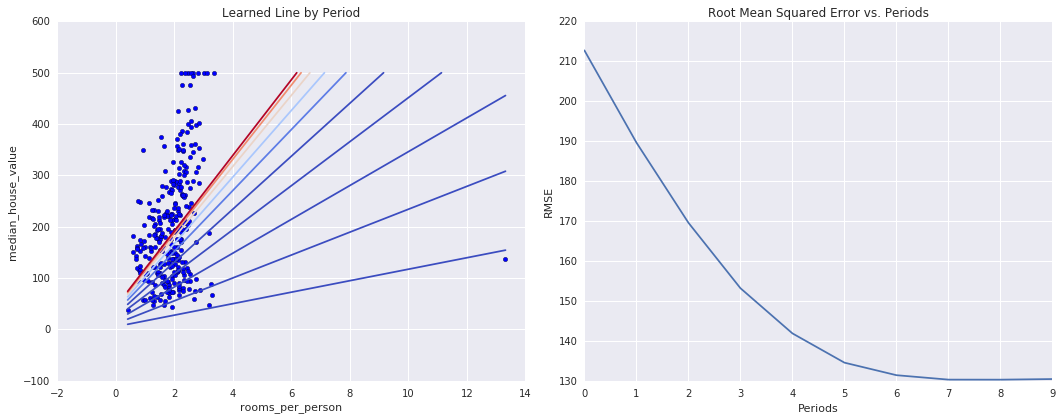

In [4]:
california_housing_dataframe["rooms_per_person"] = (
    california_housing_dataframe["total_rooms"] / california_housing_dataframe["population"])

calibration_data = train_model(
    learning_rate=0.05,
    steps=500,
    batch_size=5,
    input_feature="rooms_per_person")

### Solution to Task 2

The calibration data shows most scatter points aligned to a line. The line is almost vertical, but we'll come back to that later. Right now let's focus on the that deviate from the line. We notice that they are relatively few in number.

Plotting a histogram of `rooms_per_person` reveals that we have a few outliers in our input data.

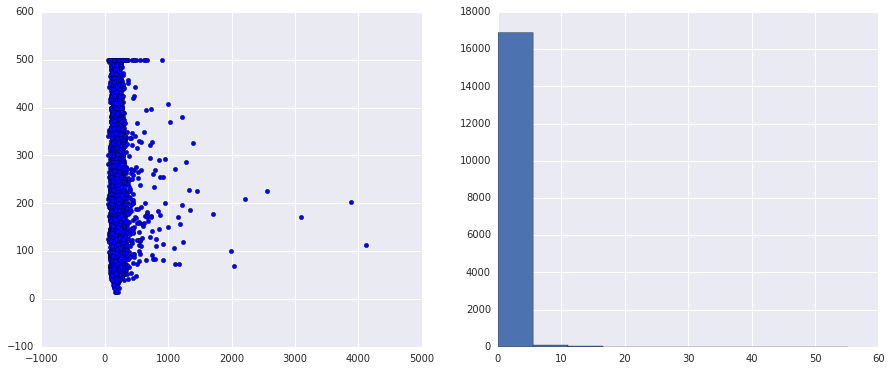

In [5]:
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.scatter(calibration_data["predictions"], calibration_data["targets"])
plt.subplot(1, 2, 2)
_ = california_housing_dataframe["rooms_per_person"].hist()

### Solution to Task 3

The histogram at Task 2 shows that the majority of values are less than `5`. Let's also plot a histogram to double check.

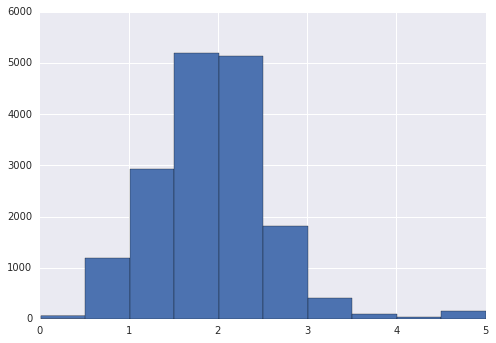

In [6]:
california_housing_dataframe["rooms_per_person"] = (
    california_housing_dataframe["rooms_per_person"]).apply(lambda x: min(x, 5))

_ = california_housing_dataframe["rooms_per_person"].hist()

To verify that clipping worked, let's train again and print the calibration data once more.

Training model...
RMSE (on training data):
  period 00 : 212.81
  period 01 : 189.05
  period 02 : 166.70
  period 03 : 146.52
  period 04 : 131.82
  period 05 : 121.46
  period 06 : 115.28
  period 07 : 111.68
  period 08 : 109.85
  period 09 : 109.10
Model training finished.


,predictions,targets
count,17000.0,17000.0
mean,188.3,207.3
std,48.7,116.0
min,45.7,15.0
25%,157.3,119.4
50%,188.4,180.4
75%,214.8,265.0
max,415.4,500.0


Final RMSE (on training data): 109.10


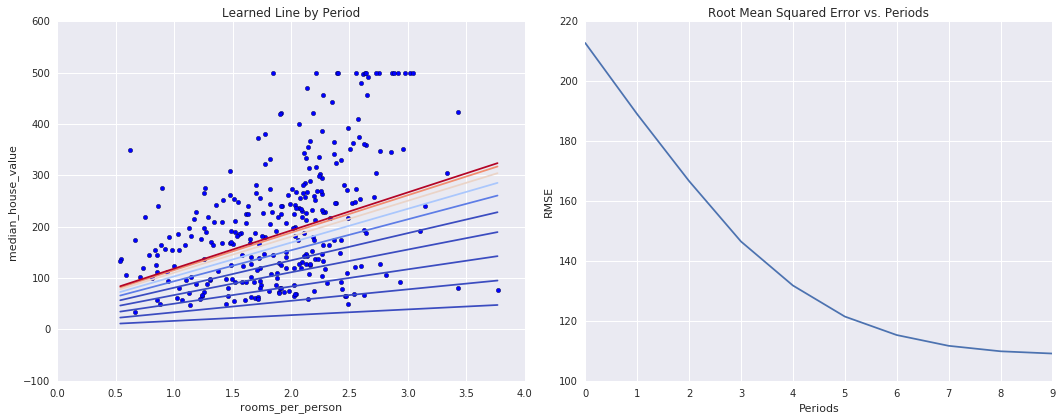

In [7]:
calibration_data = train_model(
    learning_rate=0.05,
    steps=500,
    batch_size=5,
    input_feature="rooms_per_person")

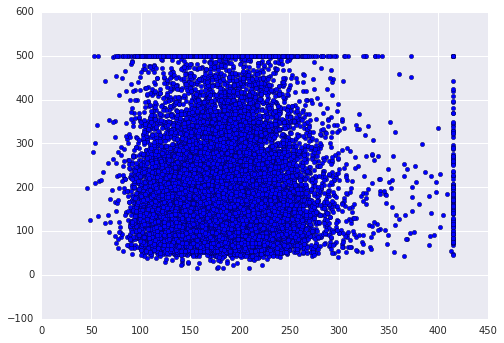

In [8]:
_ = plt.scatter(calibration_data["predictions"], calibration_data["targets"])